# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
print("Пропуски")
df.isna().sum()

Пропуски


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
print("Кол-во марок автомобилей:", len(df["Brand"].unique()))
print("Кол-во моделей автомобилей:", len(df["Model"].unique()))
print("Кузов автомобиля:", len(df["VehicleType"].unique()))
print("Средний пробег: {:.0f}".format(df["Kilometer"].mean()))

Кол-во марок автомобилей: 40
Кол-во моделей автомобилей: 251
Кузов автомобиля: 9
Средний пробег: 128211


In [7]:
df = df.drop(["PostalCode", "LastSeen", "RegistrationMonth", "RegistrationYear"], axis=1) 


df["DateCrawled"] = pd.to_datetime(df["DateCrawled"]).dt.round("D")
df["DateCreated"] = pd.to_datetime(df["DateCreated"]).dt.round("D")

In [8]:
difference = (df["DateCrawled"] - df["DateCreated"])

difference.value_counts()[:5]

1 days    276475
0 days     75390
2 days      1083
3 days       479
7 days        81
dtype: int64

Большинство данных были собраны в тот же или на следующий день после выставки на продажу. 

Поэтому сохранять оба столбца не имеет смысла - удалим DateCrawled

In [9]:
df.drop("DateCrawled", axis=1, inplace=True)

Много пропущенных значений в столбце VehicleType, пользователи часто не заполняли эту строку. 

Эти данные можно достать исходя из модели автомобиля.

In [10]:
models_vehType = df.groupby("Model")['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()

def vehicle_type_inputer(row):    
    model = row["Model"]
    veh_Type = row["VehicleType"]
    
    if model == "NG" and veh_Type == "NG":
        return "NG"
    elif model == "NG" and veh_Type != "NG":
        return veh_Type
    
    return models_vehType[model]

df["Model"] = df["Model"].fillna("NG")
df["VehicleType"] = df["VehicleType"].fillna("NG")

df["VehicleType"] = df[["VehicleType", "Model"]].apply(vehicle_type_inputer, axis=1)

In [11]:
df[df["VehicleType"]=="NG"]["VehicleType"].count()

6828

Избавились от большинства пропусков

Если NotRepaired пропущено, считаем, что продавец имеет ввиду отсутствие ремонта

In [12]:
df["NotRepaired"].fillna("yes", inplace=True)
df.dropna(inplace=True) 
df.isna().sum() 

Price               0
VehicleType         0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
DateCreated         0
NumberOfPictures    0
dtype: int64

Теперь разберемся со временем

In [13]:
df["weekday"] = df["DateCreated"].dt.weekday
df["month"] = df["DateCreated"].dt.month
df["year"] = df["DateCreated"].dt.year

df.drop('DateCreated', axis=1, inplace=True)

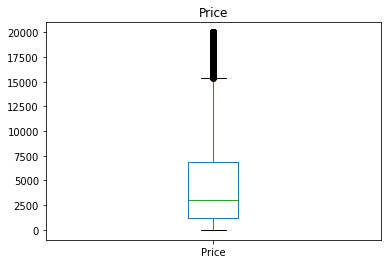

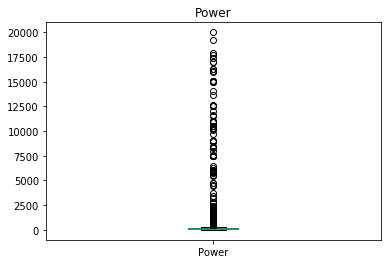

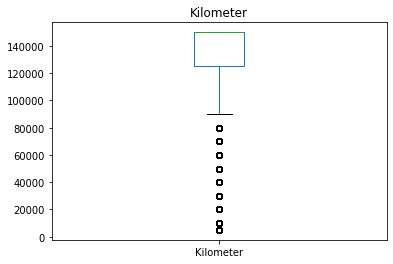

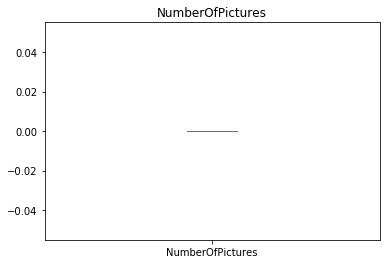

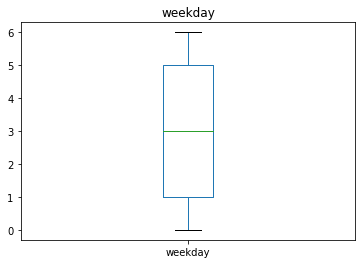

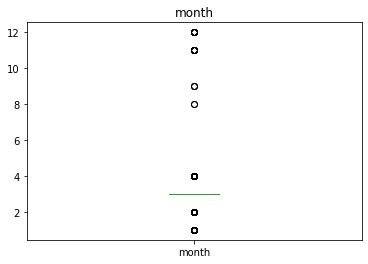

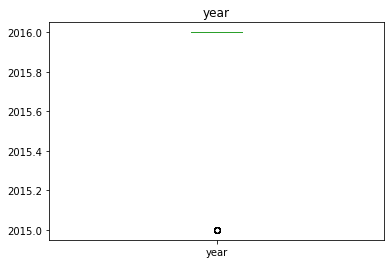

In [14]:
numerical = df.select_dtypes(include='number')

for col in numerical:
    df[col].plot.box()
    plt.title(col)
    plt.show()

### Вывод:

Мы открыли и предобработали данные

In [15]:
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures,weekday,month,year
0,480,sedan,manual,0,golf,150000,petrol,volkswagen,yes,0,3,3,2016
1,18300,coupe,manual,190,NG,125000,gasoline,audi,yes,0,3,3,2016
2,9800,suv,auto,163,grand,125000,gasoline,jeep,yes,0,0,3,2016
3,1500,sedan,manual,75,golf,150000,petrol,volkswagen,no,0,3,3,2016
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,0,3,3,2016


In [16]:
df.describe()

,Price,Power,Kilometer,NumberOfPictures,weekday,month,year
count,310561.000000,310561.000000,310561.000000,310561.0,310561.000000,310561.000000,310561.000000
mean,4699.374107,115.551434,128409.861509,0.0,2.896294,3.161166,2015.999923
std,4597.573670,179.465892,36934.413730,0.0,2.078362,0.377920,0.008791
min,0.000000,0.000000,5000.000000,0.0,0.000000,1.000000,2015.000000
25%,1200.000000,75.000000,125000.000000,0.0,1.000000,3.000000,2016.000000
50%,2999.000000,107.000000,150000.000000,0.0,3.000000,3.000000,2016.000000
75%,6880.000000,144.000000,150000.000000,0.0,5.000000,3.000000,2016.000000
max,20000.000000,20000.000000,150000.000000,0.0,6.000000,12.000000,2016.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1d669b850>,
      dtype=object)

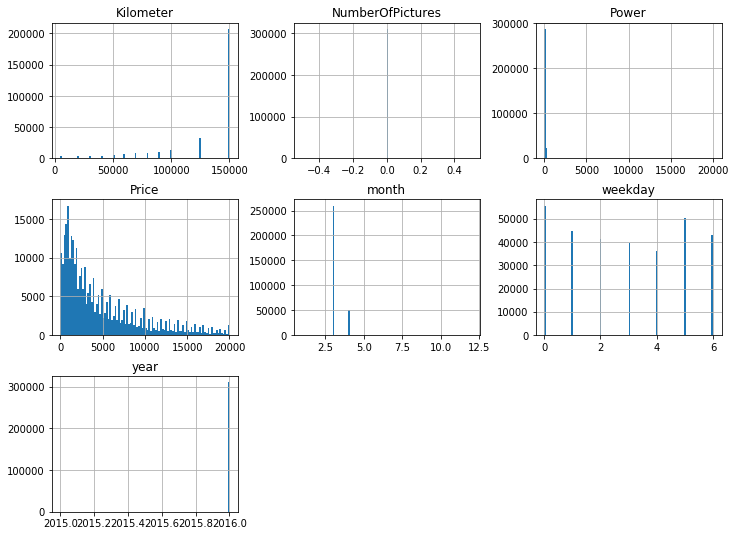

In [17]:
df.hist(bins=100, figsize=(12,9))

In [18]:
df = df.query('350 <= Price <= 7800')

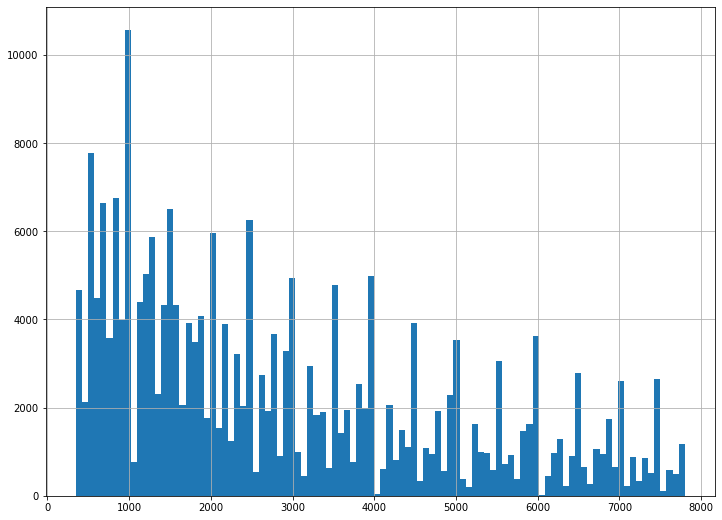

In [19]:
df['Price'].hist(bins=100, figsize=(12,9))

count    210631.000000
mean        110.044628
std          43.801573
min          25.000000
25%          75.000000
50%         103.000000
75%         136.000000
max         350.000000
Name: Power, dtype: float64

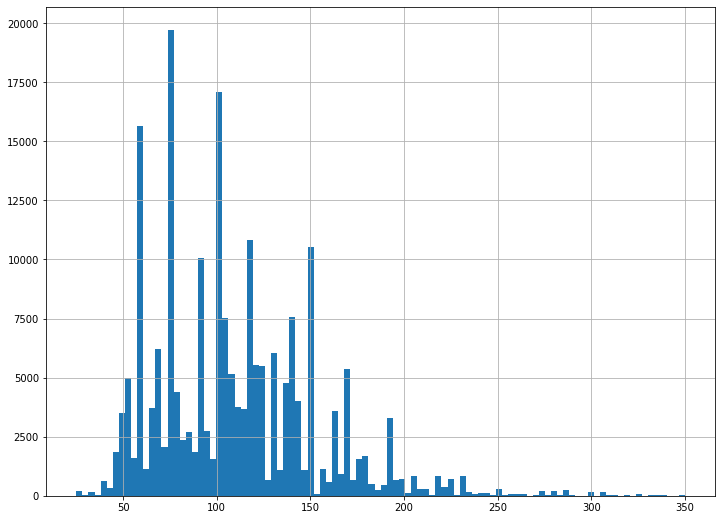

In [20]:
df = df.query('24 < Power < 351')
df['Power'].hist(bins=100, figsize=(12,9))
df['Power'].describe()

In [21]:
df['IsManualGearbox'] = 0
df.loc[df['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(df['IsManualGearbox'].value_counts())
df['Gearbox'].value_counts()

1    176955
0     33676
Name: IsManualGearbox, dtype: int64

manual    176955
auto       33676
Name: Gearbox, dtype: int64

In [22]:
df['IsNotRepaired'] = 0
df.loc[df['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
display(df['IsNotRepaired'].value_counts())
df['NotRepaired'].value_counts()

0    157847
1     52784
Name: IsNotRepaired, dtype: int64

no     157847
yes     52784
Name: NotRepaired, dtype: int64

In [23]:
df.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)
df['IsNotRepaired'] = pd.to_numeric(df['IsNotRepaired'], downcast='integer')
df['IsManualGearbox'] = pd.to_numeric(df['IsManualGearbox'], downcast='integer')
df['Power'] = pd.to_numeric(df['Power'], downcast='integer')
df['Kilometer'] = pd.to_numeric(df['Kilometer'], downcast='integer')
df['Price'] = pd.to_numeric(df['Price'], downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210631 entries, 3 to 354368
Data columns (total 13 columns):
Price               210631 non-null int16
VehicleType         210631 non-null object
Power               210631 non-null int16
Model               210631 non-null object
Kilometer           210631 non-null int32
FuelType            210631 non-null object
Brand               210631 non-null object
NumberOfPictures    210631 non-null int64
weekday             210631 non-null int64
month               210631 non-null int64
year                210631 non-null int64
IsManualGearbox     210631 non-null int8
IsNotRepaired       210631 non-null int8
dtypes: int16(2), int32(1), int64(4), int8(2), object(4)
memory usage: 16.5+ MB


In [24]:
df.head()

,Price,VehicleType,Power,Model,Kilometer,FuelType,Brand,NumberOfPictures,weekday,month,year,IsManualGearbox,IsNotRepaired
3,1500,sedan,75,golf,150000,petrol,volkswagen,0,3,3,2016,1,0
4,3600,small,69,fabia,90000,gasoline,skoda,0,3,3,2016,1,0
5,650,sedan,102,3er,150000,petrol,bmw,0,0,4,2016,1,1
6,2200,small,109,2_reihe,150000,petrol,peugeot,0,4,4,2016,1,0
10,2000,sedan,105,3_reihe,150000,petrol,mazda,0,5,3,2016,1,0


In [25]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 16.5/43.3))

Уменьшение использования памяти на 61.89%


## Обучение моделей

Мы  будем проводить обучение трёх моделей

1) CatBoost

2) LinearRegression

3) LGBMRegressor

In [26]:
categorical = df.select_dtypes(include='object').columns.to_list() + ['weekday', 'month', 'year'] # list of categorical columns

print("Столбцы категорий")
print()
print(", ".join(categorical))

Столбцы категорий

VehicleType, Model, FuelType, Brand, weekday, month, year


In [27]:
mse = mean_squared_error

In [28]:
label_encoder = LabelEncoder()

for col in categorical:
    df[col] = label_encoder.fit_transform(df[col])

In [29]:
X_with_cat = df.drop("Price", axis=1)
y = df["Price"]

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_with_cat, y, test_size=0.2, random_state=421)

In [30]:
X_with_cat

,VehicleType,Power,Model,Kilometer,FuelType,Brand,NumberOfPictures,weekday,month,year,IsManualGearbox,IsNotRepaired
3,5,75,116,150000,6,38,0,3,2,1,1,0
4,6,69,102,90000,2,31,0,3,2,1,1,0
5,5,102,11,150000,6,2,0,0,3,1,1,1
6,6,109,8,150000,6,25,0,4,3,1,1,0
10,5,105,10,150000,6,19,0,5,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354357,6,55,102,150000,6,31,0,2,2,1,1,1
354358,6,50,143,150000,6,38,0,0,3,1,1,0
354362,5,225,140,150000,6,30,0,5,2,1,1,1
354366,6,101,107,125000,6,32,0,5,2,1,0,0


### CatBoost

In [31]:
%%time
cat = CatBoostRegressor(iterations=200, depth=6, cat_features=categorical, verbose=False)
cat.fit(X_train_cat, y_train_cat)

CPU times: user 1min 49s, sys: 9.08 s, total: 1min 58s
Wall time: 2min


In [32]:
%%time
cat_pred = cat.predict(X_test_cat)

CPU times: user 226 ms, sys: 7.97 ms, total: 234 ms
Wall time: 203 ms


In [33]:
print("RMSE: ", mse(y_test_cat, cat_pred)**(.5))

RMSE:  1396.1997342559466


In [37]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=X_test_cat.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

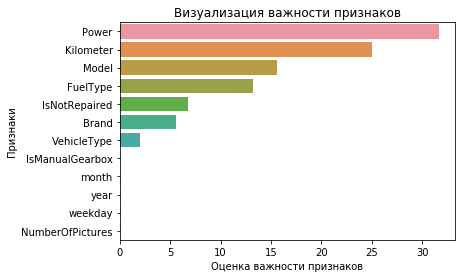

In [38]:
chart_feature_imp(cat)

### LGBM 

In [44]:
%%time
lgbm = LGBMRegressor(learning_rate=0.1, num_leaves=200, random_state= 12345)
lgbm.fit(X_train_cat, y_train_cat)

print('RMSE:', mse(y_test, lgbm.predict(X_test))**(.5))

RMSE: 1201.5818236033356
CPU times: user 6min 28s, sys: 1.42 s, total: 6min 29s
Wall time: 6min 32s


In [45]:
%%time
lgbm_pred = lgbm.predict(X_test_cat)

CPU times: user 880 ms, sys: 0 ns, total: 880 ms
Wall time: 805 ms


#### OHE

In [35]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[categorical]))

OH_cols.index = df.index

num_X = df.drop(categorical, axis=1)

OH_df = pd.concat([num_X, OH_cols], axis=1)

In [36]:
OH_df = pd.get_dummies(df, columns=categorical, drop_first=True)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_with_cat, y, test_size=0.2, random_state=421)

### Линейная регрессия

In [38]:
%%time

lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)

CPU times: user 54.5 ms, sys: 29.2 ms, total: 83.7 ms
Wall time: 58.9 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [39]:
%%time
lr_pred = lr.predict(X_test)

CPU times: user 59.1 ms, sys: 96.3 ms, total: 155 ms
Wall time: 110 ms


In [40]:
print("RMSE на тесте: ", mse(y_test, lr_pred)**(.5))

RMSE на тесте:  1633.8538457219702


### Вывод

Мы подобрали параметры и обучили 3 модели какие выводы можем сделать:

Самой быстрой моделью оказалась линейная регрессия, но catboost на порядок точнее, поэтому мы отдаём предпочтение этой моделе

модель LGBM и вовсе убивает ядро юпитера

## Анализ моделей

In [48]:
#      time rmse  
data = [["2.5 min", "229 ms", '1397'],
        ["6min", "805 ms", "1200"],
        ["81.6 ms.", "4.9 ms", '1633']]
model = ["Catboost", "LGBM", "Linear"]

In [49]:
pd.DataFrame(data=data, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Catboost,2.5 min,229 ms,1397
LGBM,6min,805 ms,1200
Linear,81.6 ms.,4.9 ms,1633


## Вывод:

Наилучшим качеством обладает модель LGBM

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей